In [1]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

# Defino funciones

In [2]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [3]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [4]:
def knn_best_distance(df,dist,x_train,y_train,x_test,y_test):
    for x in dist:
        print(x+" --------------------------")
        result , k = knn_predictor(x,x_train,y_train,x_test,y_test)
        df[x] = result
        

In [5]:
def knn_predictor(distancia,x_train,y_train,x_test,y_test):
    kesimos = []
    result = []
    for k in range(4,30):
        kesimos.append(k)
        knn = KNeighborsRegressor(n_neighbors = k, metric=distancia)
        knn.fit(x_train, y_train)
        res = predecir(knn,x_train,y_train,x_test,y_test)
        result.append(res)
    return result, kesimos

# Completo el data set

In [19]:
df = pd.read_csv('../data/test.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})

df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

df = df.drop(columns=["lat","lng","direccion","fecha","descripcion","titulo","idzona", 'gimnasio', 
                      'usosmultiples', 'piscina', 'escuelascercanas','garages',
                      'centroscomercialescercanos', 'dia'])

In [20]:
df1 = imputar(df)
imp = SimpleImputer(strategy="constant",fill_value="-")

df1["m2"]=(df1["metroscubiertos"]+df1["metrostotales"])

df_ids = df1["id"]
df1.drop(columns=["id"])

df1["tipodepropiedad"] = imp.fit_transform(df1[["tipodepropiedad"]])
df1["provincia"] = imp.fit_transform(df1[["provincia"]])
df1["ciudad"] = imp.fit_transform(df1[["ciudad"]])



In [21]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['ciudad', 'provincia', 'tipodepropiedad']

data_cols = df1._get_numeric_data().columns

baseline_data = df1[data_cols]

encoder = LabelEncoder()
encoded = df1[cat_features].apply(encoder.fit_transform)

data = baseline_data.join(encoded)

In [12]:
x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 12) y=(240000,)
Train shapes: X=(192000, 12) y=(192000,)
Test  shapes: X=(48000, 12)  y=(48000,)


# Pruebo

In [13]:
k = list(range(4,30))
prueba = pd.DataFrame(k,index=k,columns=["Kactual"])

In [14]:
dists = [
"euclidean",
"manhattan",
"chebyshev"]


knn_best_distance(prueba,dists,x_train,y_train,x_test,y_test)


euclidean --------------------------
Entrenamiento: 53.9455%
Testeo: 22.2379%.
Entrenamiento: 50.6852%
Testeo: 24.7501%.
Entrenamiento: 48.3370%
Testeo: 26.4565%.
Entrenamiento: 46.7051%
Testeo: 27.8591%.
Entrenamiento: 45.3543%
Testeo: 28.9946%.
Entrenamiento: 44.3190%
Testeo: 29.6145%.
Entrenamiento: 43.4162%
Testeo: 30.1514%.
Entrenamiento: 42.7386%
Testeo: 30.6289%.
Entrenamiento: 42.0915%
Testeo: 30.9568%.
Entrenamiento: 41.5710%
Testeo: 31.2291%.
Entrenamiento: 41.0361%
Testeo: 31.5858%.
Entrenamiento: 40.6199%
Testeo: 31.8423%.
Entrenamiento: 40.2543%
Testeo: 32.0393%.
Entrenamiento: 39.9457%
Testeo: 32.0890%.
Entrenamiento: 39.6360%
Testeo: 32.2308%.
Entrenamiento: 39.3325%
Testeo: 32.3871%.
Entrenamiento: 39.0769%
Testeo: 32.4838%.
Entrenamiento: 38.8388%
Testeo: 32.5656%.
Entrenamiento: 38.5718%
Testeo: 32.6372%.
Entrenamiento: 38.3453%
Testeo: 32.6550%.
Entrenamiento: 38.1446%
Testeo: 32.6537%.
Entrenamiento: 37.9483%
Testeo: 32.6762%.
Entrenamiento: 37.7570%
Testeo: 32.6453

In [22]:
prueba.drop(columns="Kactual",inplace=True)

KeyError: "['Kactual'] not found in axis"

(25, -0.1)

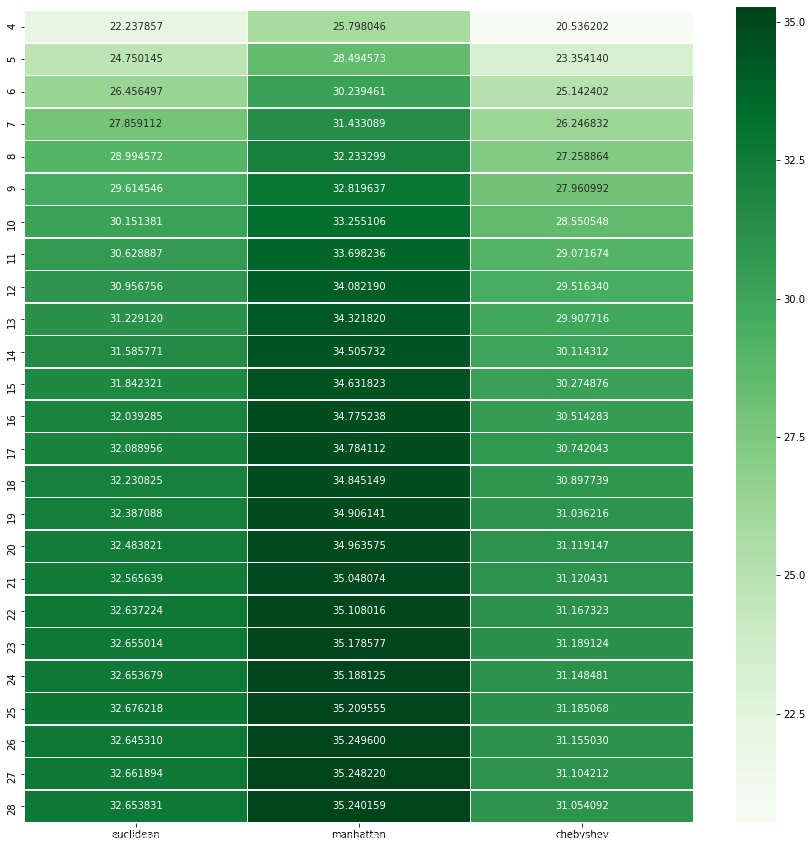

In [23]:
a= prueba.transform(lambda x: x*100)
plt.figure(figsize=(15, 15))

sns.heatmap(a, annot=True, fmt='.6f', linewidths=.5,cmap="Greens").set_ylim(25,-0.1)

In [24]:
knn = KNeighborsRegressor(n_neighbors =26, metric="manhattan")

knn.fit(x_train, y_train)

res = predecir(knn,x_train,y_train,x_test,y_test)

Entrenamiento: 40.2340%
Testeo: 35.2496%.


# Result de test

In [28]:
#Resultado de test
knn = KNeighborsRegressor(n_neighbors =26, metric="manhattan")

#Entreno con todo el dataset
knn.fit(x, y)

#Predigo la data
predict = knn.predict(data)

In [48]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")

In [49]:
result.to_csv("../data/results/resultKNN.csv", index=False)

In [50]:
result.head()

,id,target
0,4941,3692284
1,51775,785776
2,115253,1931576
3,299321,2016357
4,173570,774685


In [ ]:
# Create a ZipFile Object
with ZipFile('sample2.zip', 'w') as zipObj2:
   # Add multiple files to the zip
   zipObj2.write('sample_file.csv')